# Somatic vs non-somatic classification

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

In [1]:
%run setup_environment.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

## Get the data

In [2]:
# get raw data
impact = pd.read_csv('../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)

In [3]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%


In [4]:
# create the is_somatic class
impact['is_somatic'] = impact.confidence_class != "UNLIKELY"
get_table(impact.is_somatic)

,count_,freq_
True,187012,96.3%
False,7199,3.7%


In [5]:
# choose label
label = 'is_somatic'

# choose features
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
            'gene_type']
impact = impact[features + [label]].dropna()
    
# transform categorical features
categorical_features = ['VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']
impact = pd.get_dummies(impact, columns=categorical_features, sparse=True)

# get reduced dataset
impact = pd.concat([impact[~impact.is_somatic],
                    impact[impact.is_somatic].iloc[0:20000]], ignore_index=True)

# shuffle data
rng = np.random.RandomState(42)
permutation = rng.permutation(len(impact))
impact = impact.iloc[permutation]
impact.reset_index(drop=True, inplace=True)

# get features matrix X (n_samples x n_features) and target array y (n_samples)
X = impact.drop(label, axis=1)
y = impact[label]

print(X.shape)
print(y.shape)
get_table(y)

(27199, 45)
(27199,)


,count_,freq_
True,20000,73.5%
False,7199,26.5%


In [6]:
impact.head()

,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,sample_coverage,frequency_in_normals,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_total_AF_AFR,VEP_gnomAD_total_AF_AMR,VEP_gnomAD_total_AF_ASJ,VEP_gnomAD_total_AF_EAS,VEP_gnomAD_total_AF_FIN,VEP_gnomAD_total_AF_NFE,VEP_gnomAD_total_AF_OTH,VEP_gnomAD_total_AF_max,VEP_gnomAD_total_AF,Kaviar_AF,is_somatic,VEP_Consequence_frameshift_variant,VEP_Consequence_inframe_deletion,VEP_Consequence_inframe_insertion,VEP_Consequence_missense_variant,VEP_Consequence_splice_acceptor_variant,VEP_Consequence_splice_donor_variant,VEP_Consequence_start_lost,VEP_Consequence_stop_gained,VEP_Consequence_stop_lost,VEP_VARIANT_CLASS_SNV,VEP_VARIANT_CLASS_deletion,VEP_VARIANT_CLASS_indel,VEP_VARIANT_CLASS_insertion,VEP_VARIANT_CLASS_substitution,VEP_IMPACT_HIGH,VEP_IMPACT_MODERATE,VEP_CLIN_SIG_benign,VEP_CLIN_SIG_pathogenic,VEP_CLIN_SIG_unknown,VEP_in_dbSNP_False,VEP_in_dbSNP_True,gene_type_oncogene,gene_type_oncogene_and_tsg,gene_type_tsg,gene_type_unknown
0,807,0.11276,91,312,0.0,0,824,0.0,0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,True,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0
1,584,0.05822,34,383,0.0,0,632,0.0,3,0.000012,0.0,0.00003,0.0,0.0,0.0,0.000018,0.0,0.000030,0.000014,0.000007,True,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0
2,673,0.51263,345,485,0.0,0,672,0.0,0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,True,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0
3,964,0.30498,294,371,0.0,0,669,0.0,14959,0.000004,0.0,0.00000,0.0,0.0,0.0,0.000009,0.0,0.000009,0.000005,0.000013,True,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0
4,366,0.36885,135,190,0.0,0,451,0.0,78,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000007,True,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0


## Main imports and definitions

We choose stratified folds (made by preserving the percentage of samples for each class) for both outer and nested cross-validation.

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

## Dummy

### Uniform

Generates predictions uniformly at random, expected accuracy: 0.5 | expected AUC: 0.5.

In [8]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='uniform', random_state=42)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done! (0.57s)
▴ Mean accuracy: 0.501 ± 0.012
▴ Mean ROC AUC : 0.500 ± 0.000


In [9]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy: [test_accuracy | train_accuracy]
  → ROC AUC : [test_roc_auc  | train_roc_auc] 

Fold 1: [0.06s | 0.00s]
  → accuracy: [0.506 | 0.497]
  → ROC AUC : [0.500 | 0.500]
Fold 2: [0.05s | 0.00s]
  → accuracy: [0.498 | 0.499]
  → ROC AUC : [0.500 | 0.500]
Fold 3: [0.05s | 0.00s]
  → accuracy: [0.492 | 0.502]
  → ROC AUC : [0.500 | 0.500]
Fold 4: [0.05s | 0.00s]
  → accuracy: [0.505 | 0.501]
  → ROC AUC : [0.500 | 0.500]
Fold 5: [0.05s | 0.00s]
  → accuracy: [0.506 | 0.500]
  → ROC AUC : [0.500 | 0.500]


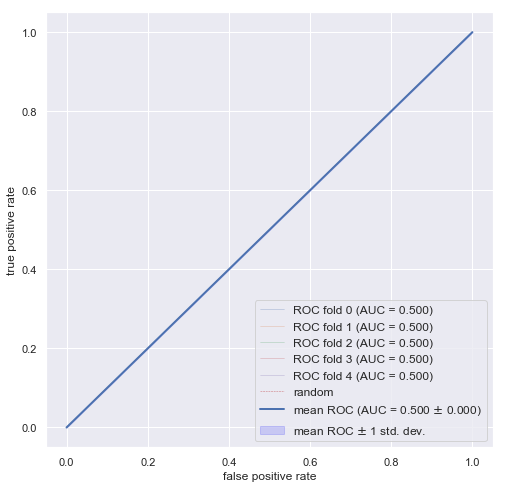

In [10]:
plot_roc(metrics, figsize=(8, 8))

### Most Frequent

Always predicts the most frequent label in the training set → expected accuracy: proportion of the most reccurent class in the dataset | expected AUC: 0.5

In [11]:
model = DummyClassifier(strategy='most_frequent', random_state=42)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done! (0.52s)
▴ Mean accuracy: 0.735 ± 0.000
▴ Mean ROC AUC : 0.500 ± 0.000


In [12]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy: [test_accuracy | train_accuracy]
  → ROC AUC : [test_roc_auc  | train_roc_auc] 

Fold 1: [0.05s | 0.00s]
  → accuracy: [0.735 | 0.735]
  → ROC AUC : [0.500 | 0.500]
Fold 2: [0.05s | 0.00s]
  → accuracy: [0.735 | 0.735]
  → ROC AUC : [0.500 | 0.500]
Fold 3: [0.05s | 0.00s]
  → accuracy: [0.735 | 0.735]
  → ROC AUC : [0.500 | 0.500]
Fold 4: [0.05s | 0.00s]
  → accuracy: [0.735 | 0.735]
  → ROC AUC : [0.500 | 0.500]
Fold 5: [0.05s | 0.00s]
  → accuracy: [0.735 | 0.735]
  → ROC AUC : [0.500 | 0.500]


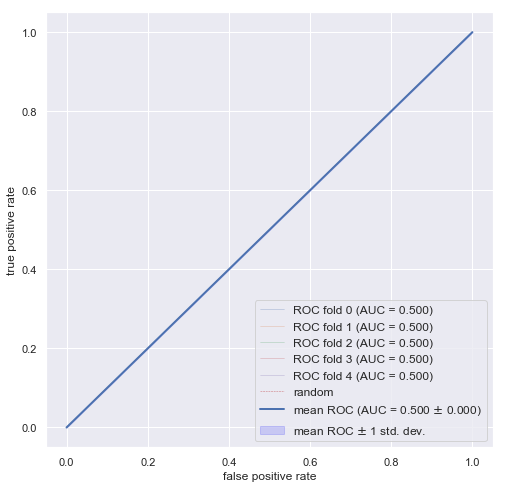

In [13]:
plot_roc(metrics, figsize=(8, 8))

## Gaussian Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done! (0.95s)
▴ Mean accuracy: 0.811 ± 0.009
▴ Mean ROC AUC : 0.834 ± 0.009


In [15]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy: [test_accuracy | train_accuracy]
  → ROC AUC : [test_roc_auc  | train_roc_auc] 

Fold 1: [0.07s | 0.01s]
  → accuracy: [0.814 | 0.810]
  → ROC AUC : [0.838 | 0.833]
Fold 2: [0.08s | 0.01s]
  → accuracy: [0.815 | 0.813]
  → ROC AUC : [0.835 | 0.836]
Fold 3: [0.07s | 0.01s]
  → accuracy: [0.815 | 0.814]
  → ROC AUC : [0.838 | 0.836]
Fold 4: [0.07s | 0.01s]
  → accuracy: [0.804 | 0.813]
  → ROC AUC : [0.827 | 0.837]
Fold 5: [0.07s | 0.01s]
  → accuracy: [0.808 | 0.813]
  → ROC AUC : [0.833 | 0.834]


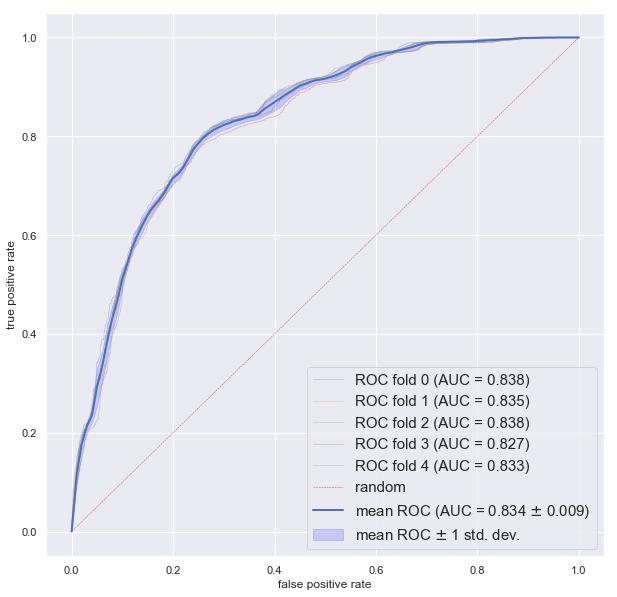

In [19]:
plot_roc(metrics)

## Logistic Regression

### Ridge regression (L2 regularization)

This model performs an automatic grid search over its parameters.

In [62]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', max_iter=3000, n_jobs=-1, random_state=42)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model...

/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


 done! (46.18s)
▴ Mean accuracy: 0.866 ± 0.010
▴ Mean ROC AUC : 0.885 ± 0.012


In [46]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy: [test_accuracy | train_accuracy]
  → ROC AUC : [test_roc_auc  | train_roc_auc] 

Fold 1: [8.85s | 0.01s]
  → accuracy: [0.870 | 0.866]
  → ROC AUC : [0.888 | 0.883]
Fold 2: [6.73s | 0.01s]
  → accuracy: [0.859 | 0.864]
  → ROC AUC : [0.875 | 0.884]
Fold 3: [10.95s | 0.01s]
  → accuracy: [0.871 | 0.869]
  → ROC AUC : [0.888 | 0.888]
Fold 4: [9.13s | 0.01s]
  → accuracy: [0.862 | 0.868]
  → ROC AUC : [0.881 | 0.887]
Fold 5: [10.21s | 0.01s]
  → accuracy: [0.868 | 0.866]
  → ROC AUC : [0.890 | 0.884]


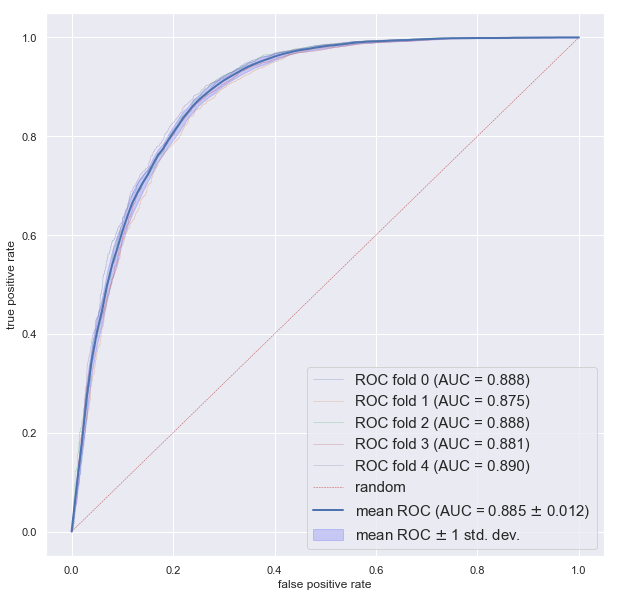

In [47]:
plot_roc(metrics)

### Lasso regression (L1 regularization)

In [68]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
print(X_poly.shape)

(27199, 1081)


In [ ]:
X_poly.head()

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(cv=nested_cv_strategy, penalty='l1', solver='liblinear', scoring='roc_auc', n_jobs=-1, random_state=42)

metrics = run_model(model, X_poly, y, cv_strategy)
print_mean_metrics(metrics)

Run model...

/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [61]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(cv=nested_cv_strategy, penalty='l1', solver='liblinear', scoring='roc_auc', n_jobs=-1, random_state=42)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done! (22.76s)
▴ Mean accuracy: 0.880 ± 0.004
▴ Mean ROC AUC : 0.898 ± 0.009


In [55]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy: [test_accuracy | train_accuracy]
  → ROC AUC : [test_roc_auc  | train_roc_auc] 

Fold 1: [4.57s | 0.01s]
  → accuracy: [0.883 | 0.880]
  → ROC AUC : [0.904 | 0.897]
Fold 2: [4.45s | 0.01s]
  → accuracy: [0.878 | 0.880]
  → ROC AUC : [0.894 | 0.900]
Fold 3: [4.50s | 0.01s]
  → accuracy: [0.881 | 0.880]
  → ROC AUC : [0.898 | 0.899]
Fold 4: [4.68s | 0.01s]
  → accuracy: [0.878 | 0.882]
  → ROC AUC : [0.894 | 0.901]
Fold 5: [4.61s | 0.01s]
  → accuracy: [0.880 | 0.880]
  → ROC AUC : [0.901 | 0.898]


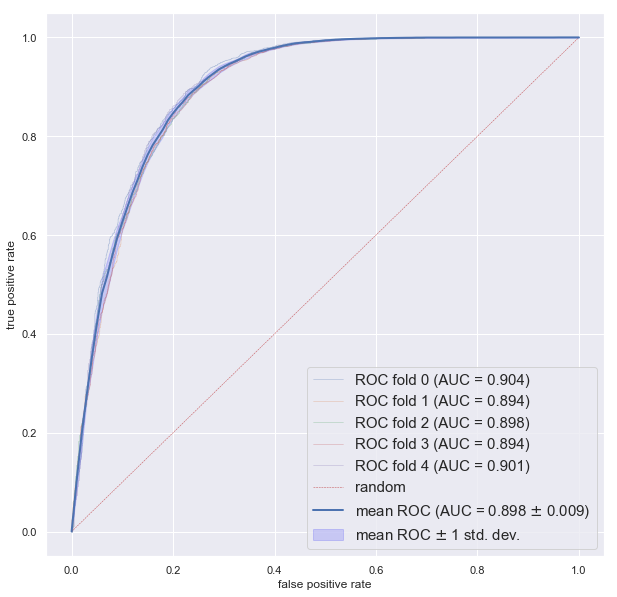

In [56]:
plot_roc(metrics)

## K Nearest Neighbors

In [22]:
job = Selene_Job('KNN', 'guilminp')

➞ mkdir on local computer ssh_remote_jobs/job_KNN


<span style='color:green'>Job < KNN >: </span>✅ created<br>

In [23]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_KNN


<span style='color:green'>Job < KNN >: </span>✅ data loaded<br>

In [24]:
%%writefile {job.local_job_directory_path}/script.py

# load the ml_tools functions
print('Setup environment...', end='')
import sys
sys.path.append("../../")

from ml_tools import *
print(' done!')


# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
inner_cv_strategy = StratifiedKFold(n_splits=3)

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# choose a model
from sklearn.neighbors import KNeighborsClassifier

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

parameters_grid = [
    {'classify__n_neighbors': [2, 10, 20, 30, 40, 50, 60, 100], 'classify__weights': ['uniform', 'distance']}
]

pipe = Pipeline([('scale'   , StandardScaler()),
                 ('classify', KNeighborsClassifier())])

model = GridSearchCV(pipe, parameters_grid, cv=inner_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)

# run the model
metrics = run_model(model, X, y, cv_strategy, grid_search=True, n_jobs=5)


print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print('' done!'')

Writing ssh_remote_jobs/job_KNN/script.py


In [25]:
job.run(n_jobs=5, short_job=False)

➞ scp ssh_remote_jobs/job_KNN to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.py                                     100% 1273    52.8KB/s   00:00    
X.pkl                                         100% 5266KB   9.8MB/s   00:00    
y.pkl                                         100%  452KB  14.5MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ launch job in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_KNN
Job <28294264> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -n 5 -R "span[ptile=5]" "python script.py"


<span style='color:green'>Job < KNN >: </span>✅ submitted<br>

In [131]:
job = Selene_Job('KNN', 'guilminp', load_from_id=True)
job.get_results()

<span style='color:green'>Job < KNN >: </span>✅ job found and reloaded<br>

<span style='color:green'>Job < KNN >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_KNN to ssh_remote_jobs/job_KNN
metrics.pkl                                   100%   96KB   4.1MB/s   00:00    
job_output.txt                                100%  273KB   7.4MB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy: 0.88 ± 0.01
▴ Mean ROC AUC : 0.91 ± 0.01


In [138]:
print_fold_metrics(job.metrics, grid_search = 'True')

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [1687.53s | 80.27s]
  → accuracy: [0.88 | 1.00]
  → ROC AUC : [0.91 | 1.00]
  → Best parameters : {'classify__n_neighbors': 30, 'classify__weights': 'distance'}
Fold 2: [2206.01s | 20.64s]
  → accuracy: [0.88 | 1.00]
  → ROC AUC : [0.91 | 1.00]
  → Best parameters : {'classify__n_neighbors': 30, 'classify__weights': 'distance'}
Fold 3: [2185.80s | 25.03s]
  → accuracy: [0.87 | 1.00]
  → ROC AUC : [0.91 | 1.00]
  → Best parameters : {'classify__n_neighbors': 30, 'classify__weights': 'distance'}
Fold 4: [2162.04s | 37.70s]
  → accuracy: [0.88 | 1.00]
  → ROC AUC : [0.92 | 1.00]
  → Best parameters : {'classify__n_neighbors': 30, 'classify__weights': 'distance'}
Fold 5: [1791.35s | 56.11s]
  → accuracy: [0.87 | 1.00]
  → ROC AUC : [0.91 | 1.00]
  → Best parameters : {'classify__n_neighbors': 30, 'classify__weights': 'distance'}


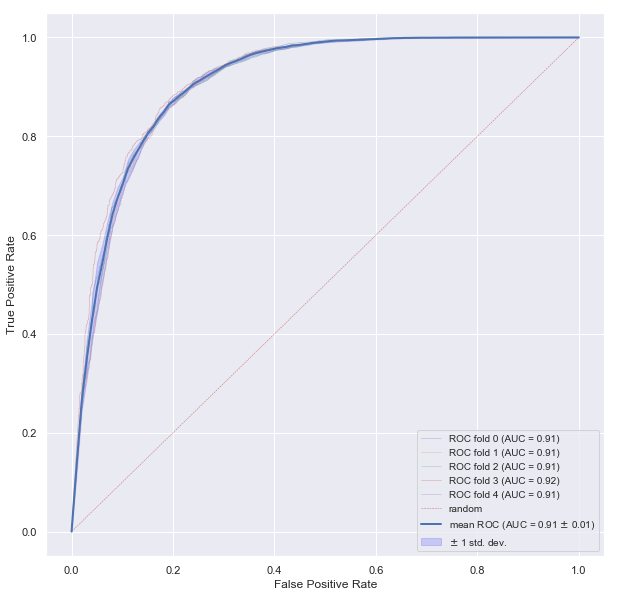

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_roc(job.metrics, ax)

2 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → classify__n_neighbors: [2 10 20 30 40 50 60 100]
  → classify__weights    : ['distance' 'uniform']


/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/guilminp/anacon

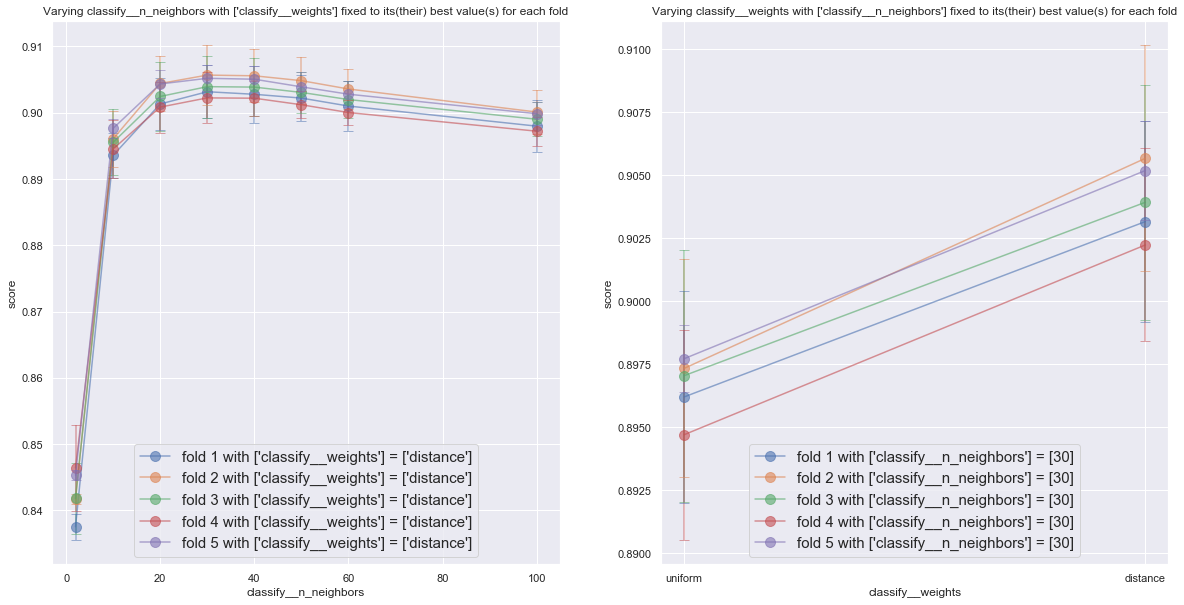

In [132]:
plot_grid_search_results(job.metrics, plot_error_bar = True)

## Random Forest

### Create job

In [49]:
job = Selene_Job('RandomForest', 'guilminp')

➞ mkdir on local computer ssh_remote_jobs/job_RandomForest


<span style='color:green'>Job < RandomForest >: </span>✅ created<br>

In [50]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_RandomForest


<span style='color:green'>Job < RandomForest >: </span>✅ data loaded<br>

In [16]:
%%writefile {job.local_job_directory_path}/script.py

# load the ml_tools functions
print('Setup environment...', end='')
import sys
sys.path.append('../../')

from ml_tools import *
print(' done!')


# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
inner_cv_strategy = StratifiedKFold(n_splits=3)

from sklearn.model_selection import GridSearchCV

# choose a model
from sklearn.ensemble import RandomForestClassifier

parameters_grid = [
    {'n_estimators': [10, 100, 1000, 2000], 'max_depth': [5, 20, 50, 100]}
]

model = GridSearchCV(RandomForestClassifier(random_state=1), parameters_grid, cv=inner_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)

# run the model
metrics = run_model(model, X, y, cv_strategy, grid_search=True, n_jobs=5)


print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Overwriting ssh_remote_jobs/job_RandomForest/script.py


In [17]:
job.run(n_jobs=5, short_job=False, memory=16)

➞ scp ssh_remote_jobs/job_RandomForest to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.py                                     100%  915    57.3KB/s   00:00    
X.pkl                                         100% 5266KB  11.7MB/s   00:00    
y.pkl                                         100%  452KB   8.2MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ launch job in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest
Job <28294667> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -n 5 -R "span[ptile=5,mem=16]" "python script.py"


<span style='color:green'>Job < RandomForest >: </span>✅ submitted<br>

In [139]:
job = Selene_Job('RandomForest', 'guilminp', load_from_id=True)
job.get_results()

<span style='color:green'>Job < RandomForest >: </span>✅ job found and reloaded<br>

<span style='color:green'>Job < RandomForest >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest to ssh_remote_jobs/job_RandomForest
metrics.pkl                                   100%  121KB   3.4MB/s   00:00    
job_output.txt                                100% 1521   364.0KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy: 0.91 ± 0.00
▴ Mean ROC AUC : 0.94 ± 0.01


In [140]:
print_fold_metrics(job.metrics, grid_search = 'True')

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [791.52s | 4.88s]
  → accuracy: [0.91 | 1.00]
  → ROC AUC : [0.94 | 1.00]
  → Best parameters : {'max_depth': 50, 'n_estimators': 2000}
Fold 2: [927.58s | 4.82s]
  → accuracy: [0.91 | 1.00]
  → ROC AUC : [0.94 | 1.00]
  → Best parameters : {'max_depth': 100, 'n_estimators': 2000}
Fold 3: [770.37s | 8.36s]
  → accuracy: [0.90 | 1.00]
  → ROC AUC : [0.94 | 1.00]
  → Best parameters : {'max_depth': 100, 'n_estimators': 1000}
Fold 4: [815.18s | 5.22s]
  → accuracy: [0.91 | 1.00]
  → ROC AUC : [0.94 | 1.00]
  → Best parameters : {'max_depth': 50, 'n_estimators': 2000}
Fold 5: [915.10s | 4.88s]
  → accuracy: [0.90 | 1.00]
  → ROC AUC : [0.93 | 1.00]
  → Best parameters : {'max_depth': 50, 'n_estimators': 2000}


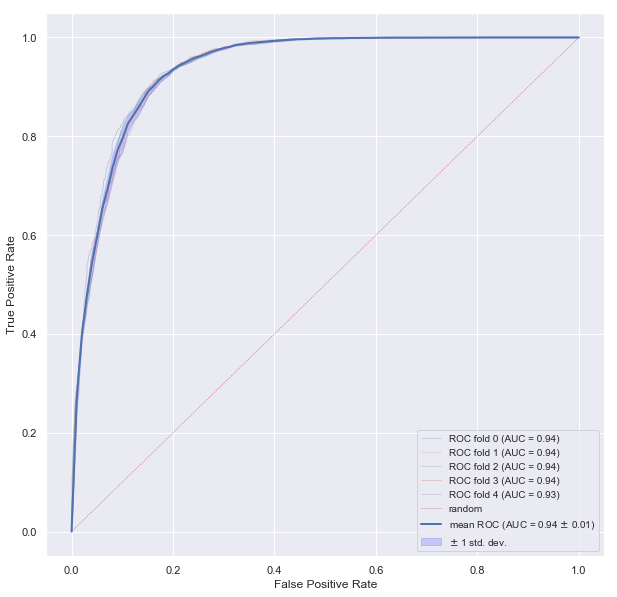

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_roc(job.metrics, ax)

2 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → max_depth   : [5 20 50 100]
  → n_estimators: [10 100 1000 2000]


/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/guilminp/anacon

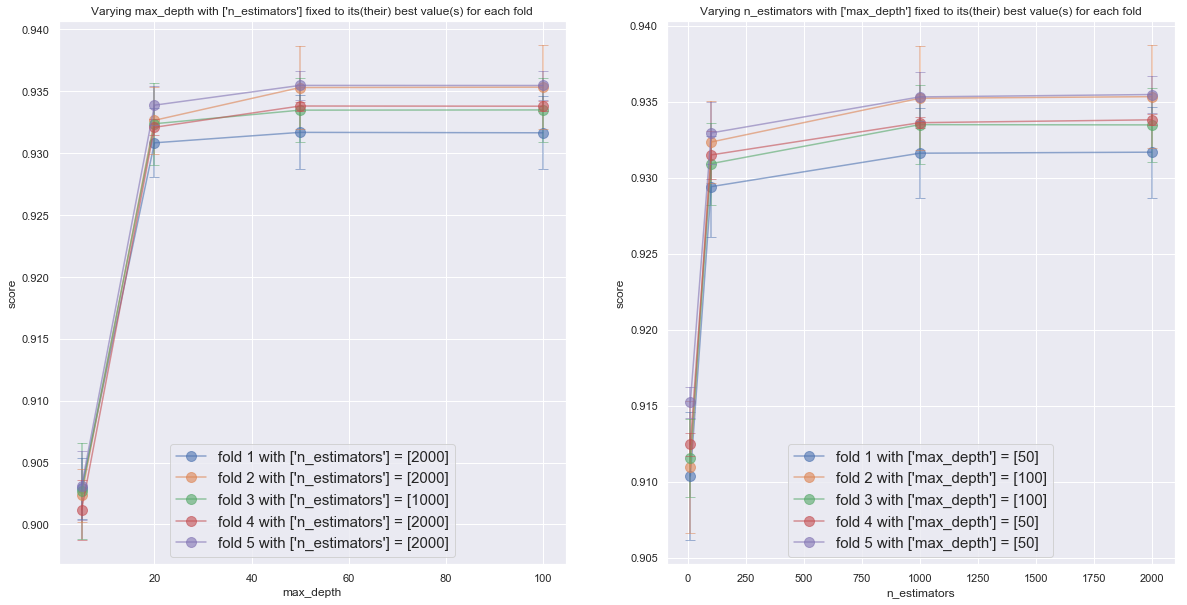

In [128]:
plot_grid_search_results(job.metrics, plot_error_bar = True)

### Study feature importance of the best hyperparameted classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier

model_best_RandomForestClassifier = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=50)
metrics = run_model(model_best_RandomForestClassifier, X, y, cv_strategy, n_jobs=5)
print_mean_metrics(metrics)

Run model... done!
▴ Mean accuracy: 0.91 ± 0.00
▴ Mean ROC AUC : 0.94 ± 0.01


In [63]:
model_best_RandomForestClassifier.fit(X, y);

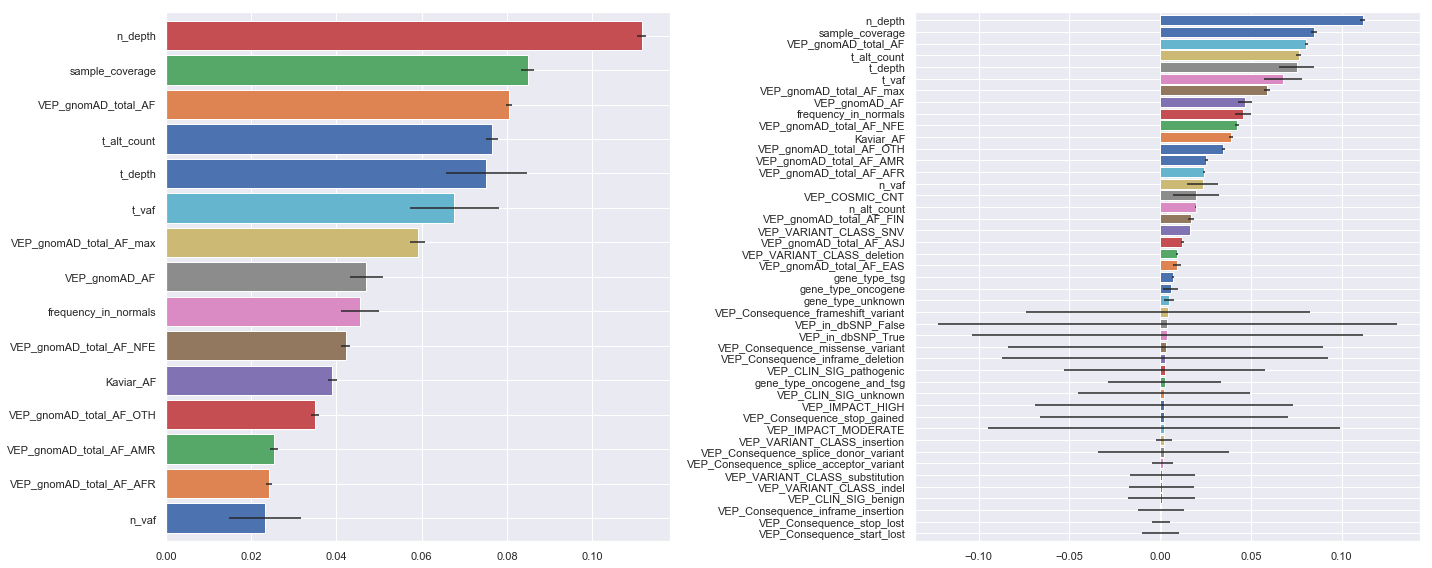

In [96]:
feature_importance = pd.DataFrame({'value': model_best_RandomForestClassifier.feature_importances_.tolist()}, index=X.columns.tolist())
feature_importance.sort_values(by='value', axis=0, inplace=True)

feature_importance['inter_tree_variability'] = np.std([tree.feature_importances_ for tree in model_best_RandomForestClassifier.estimators_], axis=0)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
feature_importance.tail(15).value.plot.barh(width=0.85, xerr=feature_importance.tail(15).inter_tree_variability)
plt.subplot(1, 2, 2)
feature_importance.value.plot.barh(width=0.85, xerr=feature_importance.inter_tree_variability)
plt.tight_layout()

## Gradient Boosting

In [105]:
job = Selene_Job('GradientBoosting', 'guilminp')

➞ mkdir on local computer ssh_remote_jobs/job_GradientBoosting


<span style='color:green'>Job < GradientBoosting >: </span>✅ created<br>

In [106]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_GradientBoosting


<span style='color:green'>Job < GradientBoosting >: </span>✅ data loaded<br>

In [107]:
%%writefile {job.local_job_directory_path}/script.py

# load the ml_tools functions
print('Setup environment...', end='')
import sys
sys.path.append('../../')

from ml_tools import *
print(' done!')


# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
inner_cv_strategy = StratifiedKFold(n_splits=3)

from sklearn.model_selection import GridSearchCV

# choose a model
from sklearn.ensemble import GradientBoostingClassifier

parameters_grid = [
    {'learning_rate': [0.01, 0.05, 0.1, 0.5, 1], 'n_estimators': [10, 100, 1000]}
]

model = GridSearchCV(GradientBoostingClassifier(random_state=1), parameters_grid, cv=inner_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)

# run the model
metrics = run_model(model, X, y, cv_strategy, grid_search=True, n_jobs=5)


print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Writing ssh_remote_jobs/job_GradientBoosting/script.py


In [108]:
job.run(n_jobs=5, short_job=False, memory=8)

➞ scp ssh_remote_jobs/job_GradientBoosting to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.py                                     100%  950   153.0KB/s   00:00    
X.pkl                                         100% 5266KB  14.6MB/s   00:00    
y.pkl                                         100%  452KB  12.5MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ launch job in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_GradientBoosting
Job <28294315> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -n 5 -R "span[ptile=5,mem=8]" "python script.py"


<span style='color:green'>Job < GradientBoosting >: </span>✅ submitted<br>

In [129]:
job = Selene_Job('GradientBoosting', 'guilminp', load_from_id=True)
job.get_results()

<span style='color:green'>Job < GradientBoosting >: </span>✅ job found and reloaded<br>

<span style='color:green'>Job < GradientBoosting >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_GradientBoosting to ssh_remote_jobs/job_GradientBoosting
metrics.pkl                                   100%   82KB   4.6MB/s   00:00    
job_output.txt                                100% 1404   561.0KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy: 0.91 ± 0.00
▴ Mean ROC AUC : 0.95 ± 0.01


In [141]:
print_fold_metrics(job.metrics, grid_search = 'True')

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [791.52s | 4.88s]
  → accuracy: [0.91 | 1.00]
  → ROC AUC : [0.94 | 1.00]
  → Best parameters : {'max_depth': 50, 'n_estimators': 2000}
Fold 2: [927.58s | 4.82s]
  → accuracy: [0.91 | 1.00]
  → ROC AUC : [0.94 | 1.00]
  → Best parameters : {'max_depth': 100, 'n_estimators': 2000}
Fold 3: [770.37s | 8.36s]
  → accuracy: [0.90 | 1.00]
  → ROC AUC : [0.94 | 1.00]
  → Best parameters : {'max_depth': 100, 'n_estimators': 1000}
Fold 4: [815.18s | 5.22s]
  → accuracy: [0.91 | 1.00]
  → ROC AUC : [0.94 | 1.00]
  → Best parameters : {'max_depth': 50, 'n_estimators': 2000}
Fold 5: [915.10s | 4.88s]
  → accuracy: [0.90 | 1.00]
  → ROC AUC : [0.93 | 1.00]
  → Best parameters : {'max_depth': 50, 'n_estimators': 2000}


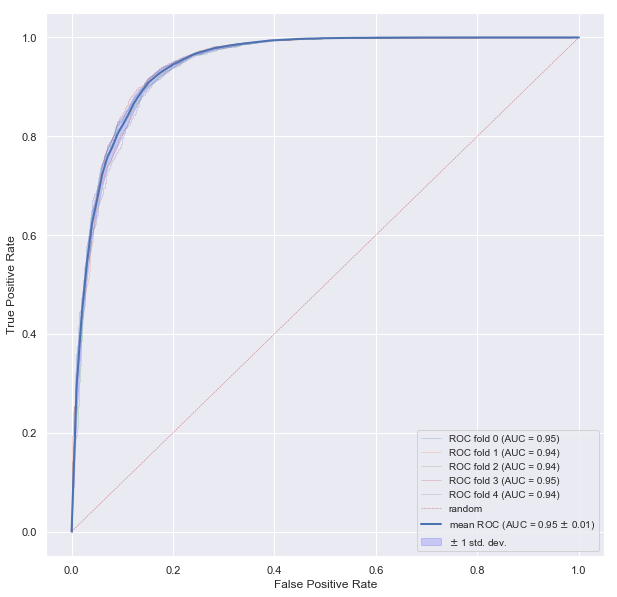

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_roc(job.metrics, ax)

2 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → learning_rate: [0.01 0.05 0.1 0.5 1]
  → n_estimators : [10 100 1000]


/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/guilminp/anacon

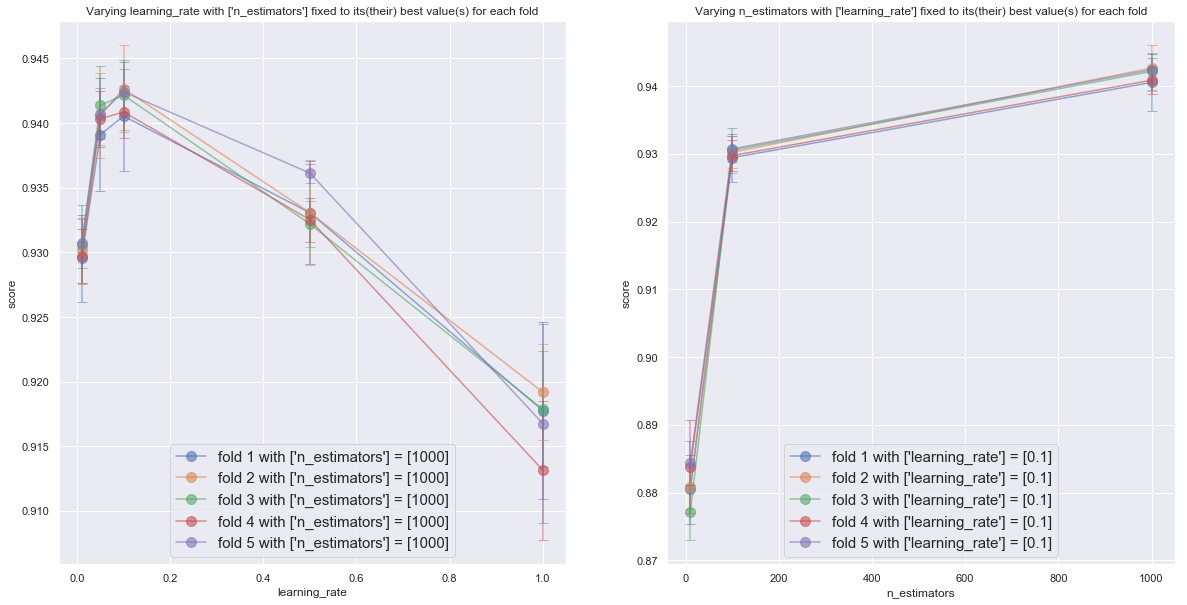

In [130]:
plot_grid_search_results(job.metrics, plot_error_bar = True)

### Study feature importance of the best hyperparameted classifier

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

model_best_GradientBoostingClassifier = GradientBoostingClassifier(random_state=1, learning_rate=0.1, n_estimators=1000, max_depth=20)
metrics = run_model(model_best_GradientBoostingClassifier, X, y, cv_strategy, n_jobs=5)
print_mean_metrics(metrics)

Run model... done!
▴ Mean accuracy: 0.90 ± 0.01
▴ Mean ROC AUC : 0.94 ± 0.01


In [13]:
model_best_GradientBoostingClassifier.fit(X, y);

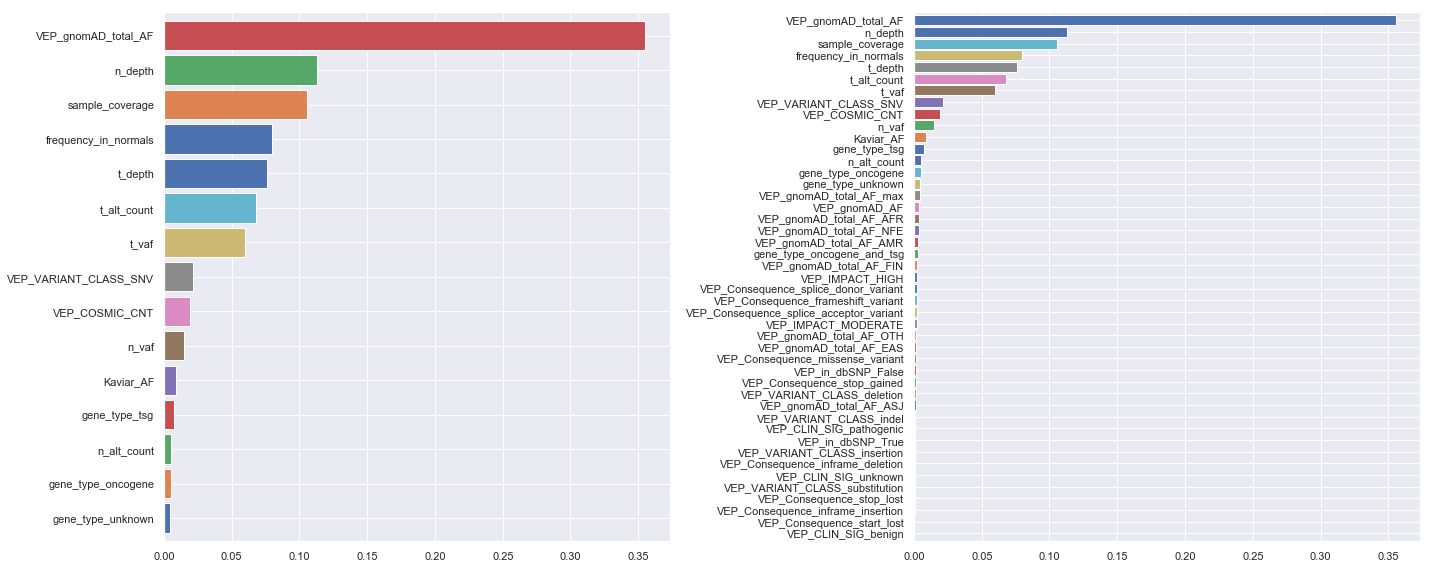

In [14]:
feature_importance = pd.DataFrame({'value': model_best_GradientBoostingClassifier.feature_importances_.tolist()}, index=X.columns.tolist())
feature_importance.sort_values(by='value', axis=0, inplace=True)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
feature_importance.tail(15).value.plot.barh(width=0.85)
plt.subplot(1, 2, 2)
feature_importance.value.plot.barh(width=0.85)
plt.tight_layout()

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = SVC(kernel='linear',probability=True, cache_size=1000)

pipe = Pipeline([('scale'   , StandardScaler()),
                 ('classify', model)])

metrics = run_model(pipe, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model...

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

parameters_grid = [
    {'classify__n_neighbors': [2, 10, 20, 30, 40, 50, 60, 100], 'classify__weights': ['uniform', 'distance']}
]

pipe = Pipeline([('scale'   , StandardScaler()),
                 ('classify', KNeighborsClassifier())])

model = GridSearchCV(pipe, parameters_grid, cv=inner_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)

# run the model
metrics = run_model(model, X, y, cv_strategy, grid_search=True, n_jobs=5)

In [ ]:
from sklearn.svm import LinearSVC

parameters_grid = [
    {'C': [0.1, 1, 10]}
]
#model_GS_SVC = GridSearchCV(SVC(), parameters_grid, cv=inner_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
model_GS_SVC = SVC(kernel='linear', probability=True)


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
run_model(model_GS_SVC, X, y, cv_strategy, grid_search=False, print_grid_search_metrics=True, print_fold_metrics=True, plot_roc=True, ax=ax)

## Other

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes = np.linspace(0.1, 1.0, 5), cv = 5)

for i in range(n_folds):
    plt.plot(train_sizes, train_scores[i], linewidth = 0.5, alpha = 0.4, color = 'r',
                     label = 'training score fold %d' % i)
    plt.plot(train_sizes, test_scores[i], linewidth = 0.5, alpha = 0.4, color = 'g',
                     label = 'test score fold %d' % i)
    
train_scores_mean = np.mean(train_scores, axis = 0)
train_scores_std = np.std(train_scores, axis = 0)
test_scores_mean = np.mean(test_scores, axis = 0)
test_scores_std = np.std(test_scores, axis = 0)

plt.plot(train_sizes, train_scores_mean, 'o-r', linewidth = 1,
        label = 'mean training score')
plt.plot(train_sizes, test_scores_mean, 'o-g', linewidth = 1,
         label = 'mean test score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')


plt.xlabel("Training size")
plt.ylabel("Accuracy score")
plt.legend(loc = "lower right", prop = {'size': 5})